<a href="https://colab.research.google.com/github/sskyau/stanford-dogs-classification-models/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment Initialisation**

##1.1 Import libraries

In [1]:
!pip install --upgrade pip
!pip install tensorflow-datasets
!pip install tensorflow_data_validation[visualization]==1.8.0 tensorflow==2.8
!pip install keract
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.3/668.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
# tf/keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_data_validation as tfdv
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.model_selection import KFold, StratifiedKFold

# utlity
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter


%load_ext tensorboard

##1.2 Check connection to GPU and drive

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


##1.3 Declare constant variables

In [5]:
IMG_SIZE = 224
NUM_BREEDS = 120
CP_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/DenseNet121/'

#**2. Load dataset**

#2.1 Load and visualise data

In [6]:
(train, val, test), info = tfds.load(name="stanford_dogs", 
                                     split=['train[:80%]+test[:80%]','train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]'],
                                     shuffle_files=True,
                                     as_supervised=True, # tuple instead of dictionary
                                     with_info=True)

In [7]:
class_labels = info.features['label'].int2str

print('Number of classes: ', info.features['label'].num_classes)
print()
print('Number of samples:')
print('Training set: ', len(train))
print('Validation set: ', len(val))
print('Testing set: ', len(test))
print()
print(info)

Number of classes:  120

Number of samples:
Training set:  16464
Validation set:  2058
Testing set:  2058

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='~/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
      

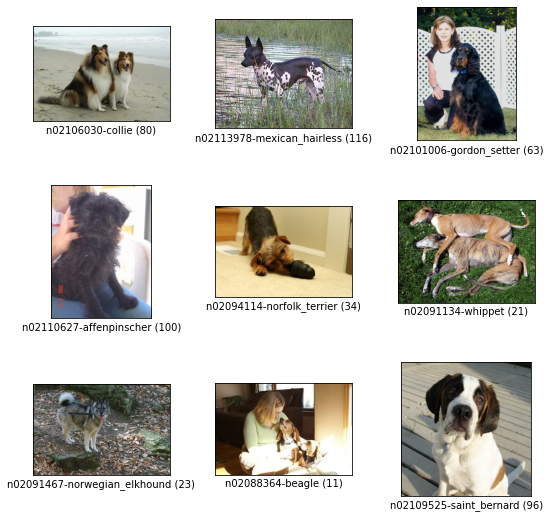

In [8]:
fig = tfds.show_examples(train, info)

#2.2 Retrieve breed list

In [8]:
breed_list = []

for filename in info.features['label'].names:
  separator = [i for i, letter in enumerate(filename) if letter == '-']
  breed_list.append(filename[separator[0]+1:])

print(breed_list)

['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih-tzu', 'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback', 'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone', 'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound', 'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound', 'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier', 'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier', 'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier', 'wire-haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier', 'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'scotch_terrier', 'tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa', 'flat-coated_retriever', 'cur

##2.3 Visualise dataset distributions

In [ ]:
train_labels, train_counts = np.unique(np.fromiter(train.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

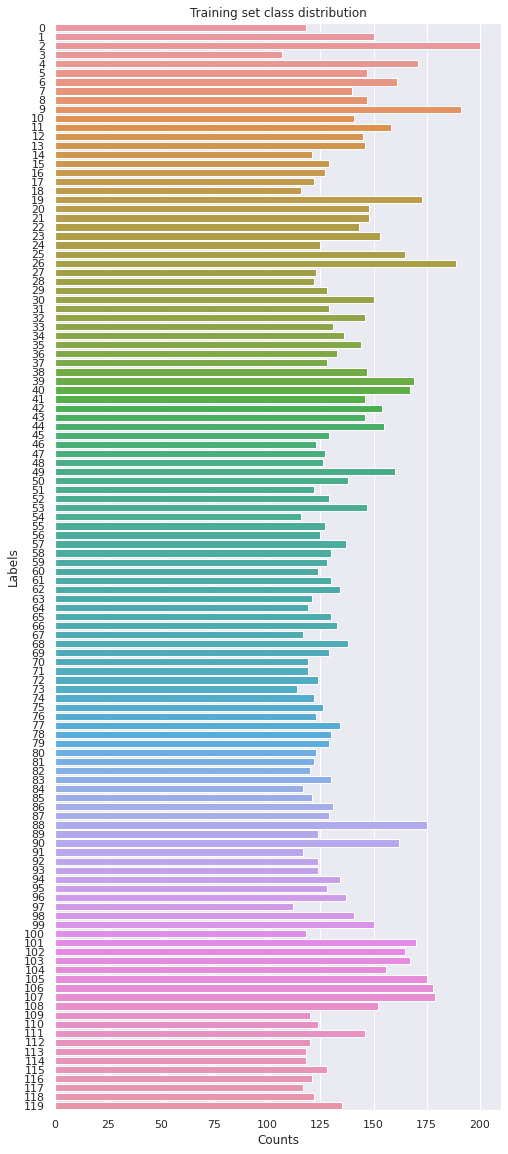

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Training set class distribution")
sns.barplot(x = train_counts, y = train_labels, orient='h') 

In [ ]:
val_labels, val_counts = np.unique(np.fromiter(val.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

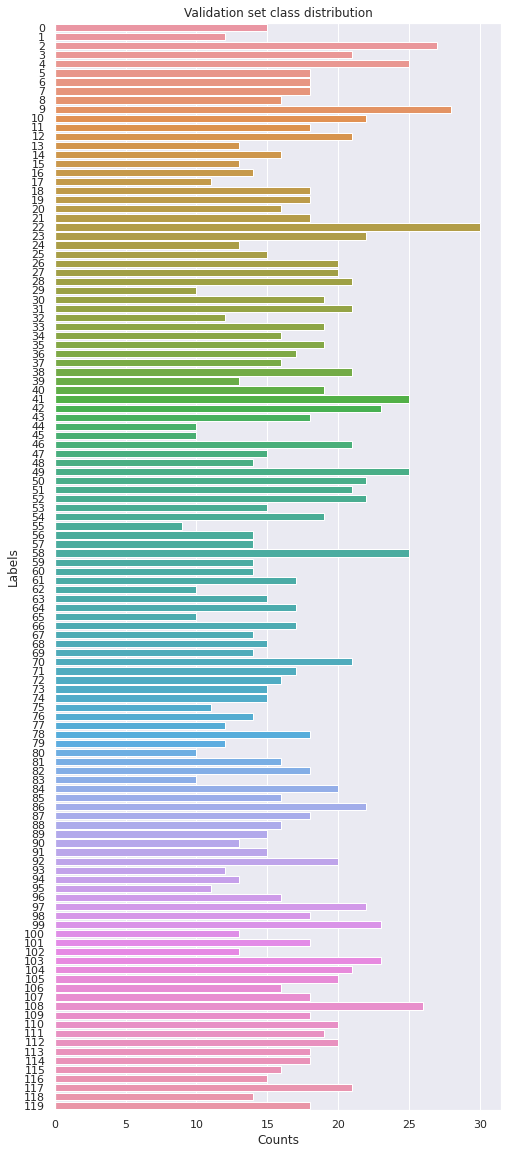

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = val_counts, y = val_labels, orient='h') 

In [ ]:
test_labels, test_counts = np.unique(np.fromiter(test.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

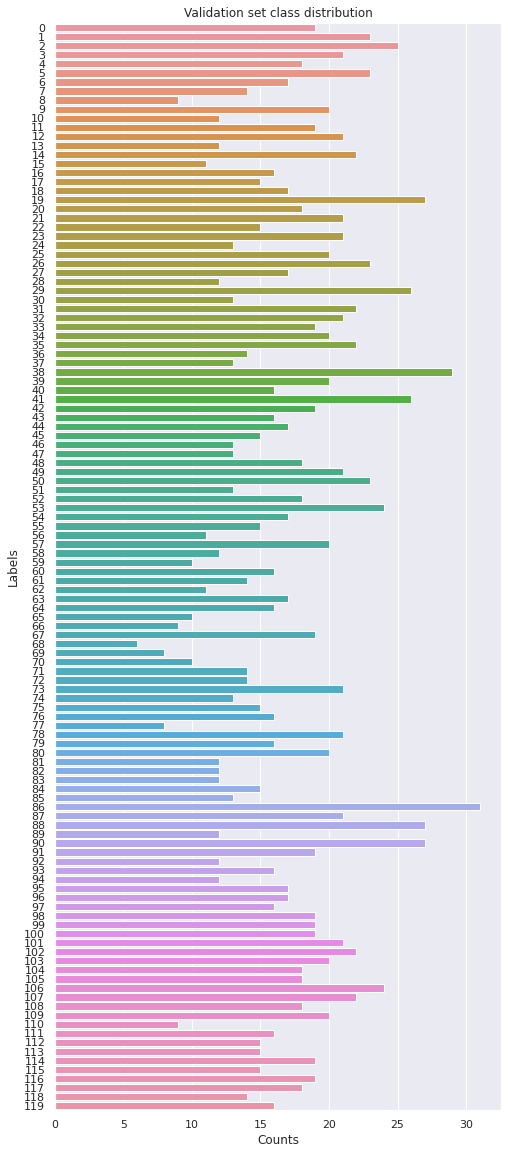

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = test_counts, y = test_labels, orient='h') 

#**3. Modelling**

##3.1 Preprocessing Layers

In [9]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64
RANDOM_SEED = 43

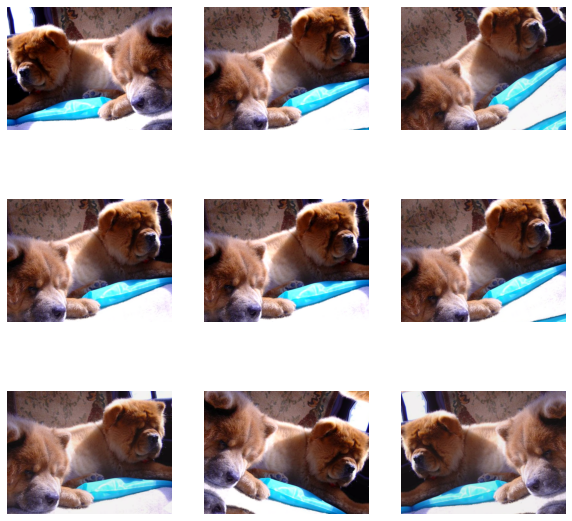

In [10]:
img_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(factor=0.1),
                                        ])

# Visualize some augmentations

ex_img, label = next(iter(train))
ex_img = tf.cast(ex_img, tf.float32) / 255.

img_batch = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_img = img_augmentation(img_batch, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_img[0])
  plt.axis("off")

In [11]:
# Efficientnet takes input images of shape (224, 224, 3) with range [0,255] --> normalisation not needed
# reference: https://keras.io/api/applications/efficientnet/#efficientnetb0-function

def one_hot(image, label):
  label = tf.one_hot(label,NUM_BREEDS)
  return image, label

def resize(image, label):
  image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
  # image = tf.cast(image, tf.float32) / 255.
  return image, label

def preprocess(image, label):
  return tf.keras.applications.densenet.preprocess_input (tf.cast(image, tf.float32)), label

# Resize and one-hot encode all datasets

ds_train = train.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_val = val.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE, drop_remainder=True)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)


ds_test = test.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


##3.2 Feature Extraction

In [12]:
def create_model():
  inputs = Input(shape=INPUT_SHAPE)
  x = img_augmentation(inputs)
  base = tf.keras.applications.densenet.DenseNet121(input_tensor=x,
                                                input_shape=INPUT_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  base.trainable = False
  x = GlobalAveragePooling2D()(base.output)
  x = layers.BatchNormalization()(x)
  x = Dense(1280, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(RANDOM_SEED), bias_initializer='zeros')(x)
  x = layers.BatchNormalization()(x)
  outputs = Dense(NUM_BREEDS, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

  return Model(inputs=inputs, outputs=outputs, name='MNV2')

In [13]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

model.summary()

Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['sequential[0][0]']             
                                                                                               

In [14]:
EPOCHS = 45
CP_PATH = CP_DIR+'FE/DN121-{epoch:02d}.h5'

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(ds_train, 
                    epochs=EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

# save the model if results are satisfactory
model.save(CP_PATH+'/model/DN121.h5')

Epoch 1/45
257/257 [==============================] - 68s 144ms/step - loss: 1.6937 - accuracy: 0.6139 - top_k_categorical_accuracy: 0.8813 - val_loss: 0.8524 - val_accuracy: 0.7485 - val_top_k_categorical_accuracy: 0.9639
Epoch 2/45
257/257 [==============================] - 33s 127ms/step - loss: 0.8517 - accuracy: 0.7471 - top_k_categorical_accuracy: 0.9612 - val_loss: 0.7454 - val_accuracy: 0.7881 - val_top_k_categorical_accuracy: 0.9683
Epoch 3/45
257/257 [==============================] - 31s 119ms/step - loss: 0.7270 - accuracy: 0.7726 - top_k_categorical_accuracy: 0.9711 - val_loss: 0.8827 - val_accuracy: 0.7666 - val_top_k_categorical_accuracy: 0.9624
Epoch 4/45
257/257 [==============================] - 31s 119ms/step - loss: 0.6563 - accuracy: 0.7951 - top_k_categorical_accuracy: 0.9758 - val_loss: 0.7965 - val_accuracy: 0.7764 - val_top_k_categorical_accuracy: 0.9717
Epoch 5/45
257/257 [==============================] - 31s 119ms/step - loss: 0.5895 - accuracy: 0.8143 - top

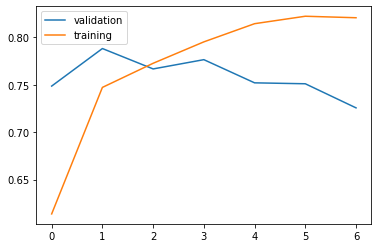

In [15]:
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='training')
plt.legend()
plt.show()

In [16]:
logname = CP_DIR + 'FE.csv'

df_fe_history = pd.DataFrame.from_dict(history.history) 
df_fe_history.to_csv(logname, index = False, header=True)

##3.3 Finetuning

In [ ]:
def print_trainable(model):
  for layer_id, layer in enumerate(model.layers):
    print(layer_id,' ' , layer.name, ": ", layer.trainable)

In [18]:
# Load the best model
ft_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/DenseNet121/FE/DN121-02.h5")

def unfreeze(model, start_layer, end_layer):
  for layer_id, layer in enumerate(model.layers):
    if layer_id >= start_layer and layer_id <= end_layer:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

unfreeze(ft_model, 0, len(ft_model.layers)-1)

In [ ]:
print_trainable(ft_model)

0   input_1 :  True
1   sequential :  True
2   zero_padding2d :  True
3   conv1/conv :  True
4   conv1/bn :  False
5   conv1/relu :  True
6   zero_padding2d_1 :  True
7   pool1 :  True
8   conv2_block1_0_bn :  False
9   conv2_block1_0_relu :  True
10   conv2_block1_1_conv :  True
11   conv2_block1_1_bn :  False
12   conv2_block1_1_relu :  True
13   conv2_block1_2_conv :  True
14   conv2_block1_concat :  True
15   conv2_block2_0_bn :  False
16   conv2_block2_0_relu :  True
17   conv2_block2_1_conv :  True
18   conv2_block2_1_bn :  False
19   conv2_block2_1_relu :  True
20   conv2_block2_2_conv :  True
21   conv2_block2_concat :  True
22   conv2_block3_0_bn :  False
23   conv2_block3_0_relu :  True
24   conv2_block3_1_conv :  True
25   conv2_block3_1_bn :  False
26   conv2_block3_1_relu :  True
27   conv2_block3_2_conv :  True
28   conv2_block3_concat :  True
29   conv2_block4_0_bn :  False
30   conv2_block4_0_relu :  True
31   conv2_block4_1_conv :  True
32   conv2_block4_1_bn :  False


In [19]:
ft_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ft_model.summary()

Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['sequential[0][0]']             
                                                                                               

In [20]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

CP_PATH = CP_DIR+'FT/DN121-{epoch:02d}.h5'

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

FT_EPOCHS = 100
ft_history = ft_model.fit(ds_train, 
                    epochs=FT_EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

Epoch 1/100
257/257 [==============================] - 120s 429ms/step - loss: 0.5499 - accuracy: 0.8250 - top_k_categorical_accuracy: 0.9819 - val_loss: 0.6019 - val_accuracy: 0.8110 - val_top_k_categorical_accuracy: 0.9766
Epoch 2/100
257/257 [==============================] - 108s 422ms/step - loss: 0.4590 - accuracy: 0.8574 - top_k_categorical_accuracy: 0.9860 - val_loss: 0.5713 - val_accuracy: 0.8257 - val_top_k_categorical_accuracy: 0.9766
Epoch 3/100
257/257 [==============================] - 107s 415ms/step - loss: 0.4244 - accuracy: 0.8695 - top_k_categorical_accuracy: 0.9886 - val_loss: 0.5846 - val_accuracy: 0.8237 - val_top_k_categorical_accuracy: 0.9766
Epoch 4/100
257/257 [==============================] - 106s 414ms/step - loss: 0.3861 - accuracy: 0.8814 - top_k_categorical_accuracy: 0.9908 - val_loss: 0.5613 - val_accuracy: 0.8242 - val_top_k_categorical_accuracy: 0.9771
Epoch 5/100
257/257 [==============================] - 108s 420ms/step - loss: 0.3634 - accuracy: 0.

In [21]:
logname = CP_DIR + 'FT.csv'

df_ft_history = pd.DataFrame.from_dict(ft_history.history) 
df_ft_history.to_csv(logname, index = False, header=True)

Analysis

In [22]:
best_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/DenseNet121/FT/DN121-07.h5")

In [23]:
best_model.evaluate(ds_test)

32/32 [==============================] - 6s 129ms/step - loss: 0.6426 - accuracy: 0.8057 - top_k_categorical_accuracy: 0.9810


[0.6426241397857666, 0.8056640625, 0.98095703125]